In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())

[CudaDevice(id=0)]


In [8]:
# Problem setup
nx = 512
nv = 512
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
L = 10 * jnp.pi
LV = 6.0
#hv = 0.1  # Example value for velocity step (modify as per your setup)
#hx = 0.1  # Example value for space step (modify as per your setup)

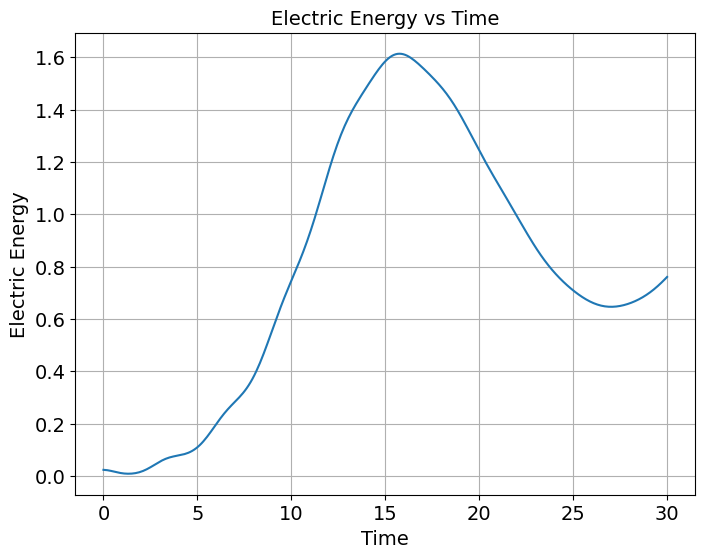

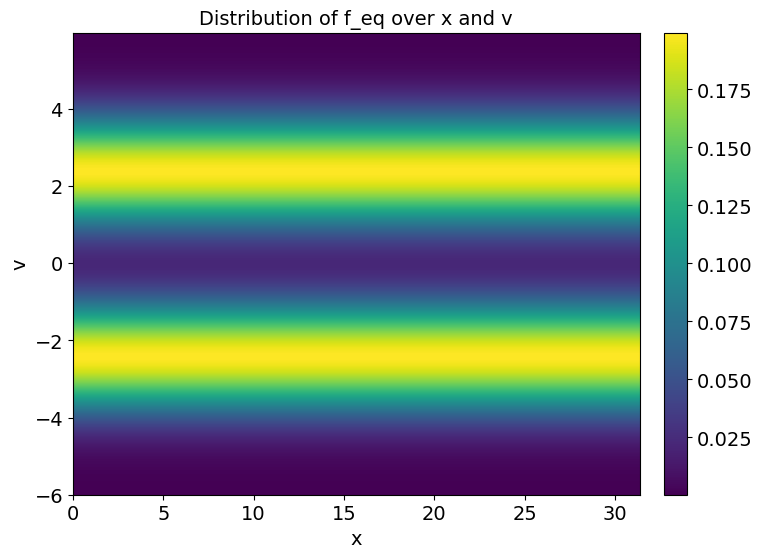

(512, 512)


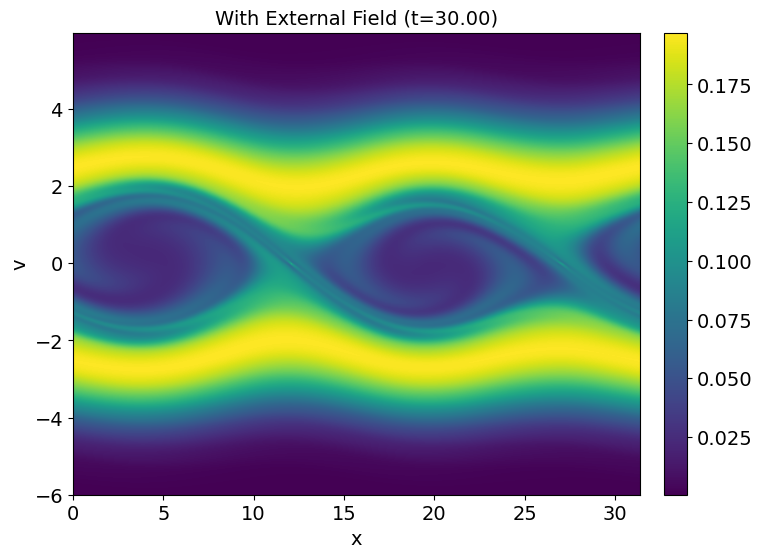

In [9]:
mesh = make_mesh(L, LV, nx, nv)

alpha = 0.5
mu1 = 2.4
mu2 = -2.4
f_eq = (alpha * jnp.exp(-0.5 * (mesh.V - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (mesh.V - mu2)**2)) / jnp.sqrt(2 * jnp.pi)
epsilon = 0.001
k_0 = 0.2
f_iv = (1.0 + epsilon * jnp.cos(k_0 * mesh.X)) * f_eq

# External field parameters (coefficients for the cosine terms)
a_k = [0.004, 0.05, -0.02, 0.0, 0.0]

# Function to compute the external field H (not time-dependent)
def compute_external_field(xs, a_k):
    H = np.zeros(len(xs))  # Initialize H as a 1D array (space)
    for k in range(1, 6):  # Iterate over k from 1 to 5
        H += a_k[k - 1] * np.cos(k * xs / L * 2 * np.pi)  # Compute H for each k and sum
    return H

# Compute the external field
H = jnp.array(compute_external_field(mesh.xs, a_k))

num_steps = int(t_final / dt)

# Function to plot the distribution of f_eq over x and v
def plot_feq_distribution(ax, f_eq, title):
    im = ax.imshow(f_eq.transpose(), extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='viridis')  # 'auto' aspect ratio
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

# Modify the plot_distribution function to handle 2D data
def plot_distribution(ax, data, title, time):
    im = ax.imshow(data.T, extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='viridis')  # Transpose data
    ax.set_title(f'{title} (t={time:.2f})')
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=jnp.array(f_eq))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Fix the unpacking here
f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=t_final)

# Create a figure with a single plot for electric energy
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final / dt))

plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

print(f_array.shape)  # This will help understand the dimensions of f_array


# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# f_array is already a 2D array, so pass it directly to the plot
plot_distribution(ax, f_array, 'With External Field', t_final)

# Display the plot
plt.show()

Initial cost J: 0.6514332294464111


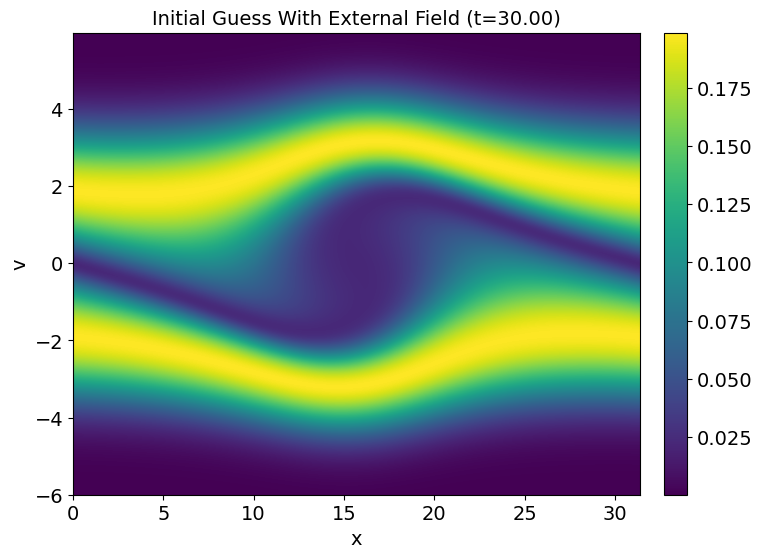

Iteration 0, Cost: 0.6514332294464111
Iteration 10, Cost: 1.3493643999099731
Iteration 20, Cost: 1.1147637367248535
Iteration 30, Cost: 0.9976072311401367
Iteration 40, Cost: 0.913335919380188
Iteration 50, Cost: 0.8447883129119873
Iteration 60, Cost: 0.7792503237724304
Iteration 70, Cost: 0.7266646027565002
Iteration 80, Cost: 0.7039013504981995
Iteration 90, Cost: 0.6840214133262634
Iteration 100, Cost: 0.6532850861549377
Iteration 110, Cost: 0.6216543316841125
Iteration 120, Cost: 0.5952970385551453
Iteration 130, Cost: 0.5793513655662537
Iteration 140, Cost: 0.5694112181663513
Iteration 150, Cost: 0.5606915354728699
Iteration 160, Cost: 0.5502317547798157
Iteration 170, Cost: 0.5352867245674133
Iteration 180, Cost: 0.5096905827522278
Iteration 190, Cost: 0.4600154459476471


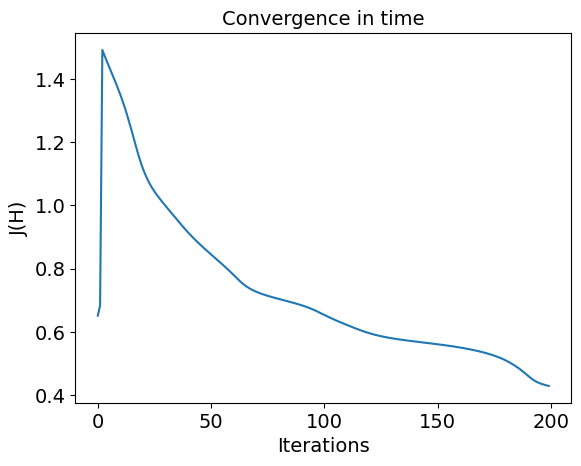

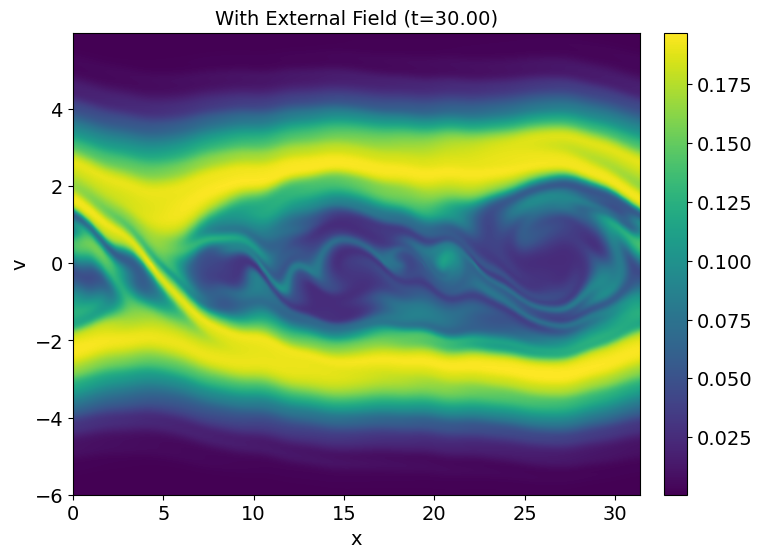

In [10]:
# Optimization through auto-differentiation with fixed basis.

# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
 -0.0, 0])

# Function to compute the external field H based on coefficients a_k
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)
    for k in range(1, 15):  # k from 1 to 11
        H += a_k[k-1] * jnp.cos(k * xs / L * 2 * jnp.pi)
    return H

# Define the cost function using JAX
def cost_function(a_k):
    H = compute_external_field(mesh.xs, a_k)
    # JIT-compiled forward solver
    solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    f_final = f_array
    cost = J(f_final, f_eq, solver)
    return cost

# Adjust the J function to use f_final
def J(f_final, f_eq, solver):
    return jnp.sum((f_final - f_eq) ** 2) * solver.mesh.dx * solver.mesh.dv

# Compute the gradient using JAX's automatic differentiation
cost_and_grad_function = jax.jit(jax.value_and_grad(cost_function))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Plot the final distribution before optimization using the initial guess of H
H_initial = compute_external_field(mesh.xs, a_k)
f_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)

f_final_initial = f_array_initial

# Print J (cost function value) for the initial guess
J_initial = J(f_final_initial, f_eq, solver)
print(f'Initial cost J: {J_initial}')

# Create a figure for the initial plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution at the final time with the initial guess
plot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)

# Display the initial plot
plt.show()

# Now proceed with the optimization loop
maxIter = 200  # Number of optimization iterations
hist_J = []

for i in range(maxIter):
    # Compute cost and gradient
    cost, grad = cost_and_grad_function(a_k)
    hist_J.append(cost)
    if i%10 == 0:
        print(f'Iteration {i}, Cost: {cost}')
        #print(f'Iteration {i}, a_k: {a_k}')  # Print the current value of a_k

    # Update a_k using a simple gradient descent step or line search
    # For simplicity, let's use gradient descent with a fixed learning rate
    learning_rate = 0.001
    a_k = a_k - learning_rate * grad
    
    # After each iteration, plot the distribution
    H = compute_external_field(mesh.xs, a_k)
    ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
    f_final = ff_array

# Plot the value of the cost function during the iteration process
plt.plot(hist_J)
plt.title('Convergence in time')
plt.ylabel('J(H)')
plt.xlabel('Iterations')
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()

Initial cost J: 0.12147831916809082


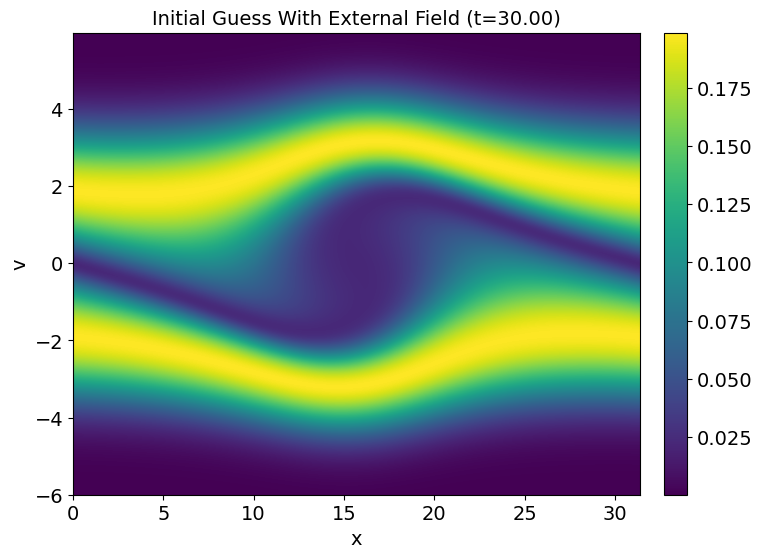

Iteration 0, Cost: 0.12147831171751022
Iteration 10, Cost: 0.15790779888629913
Iteration 20, Cost: 0.14432354271411896
Iteration 30, Cost: 0.13960589468479156
Iteration 40, Cost: 0.13681195676326752
Iteration 50, Cost: 0.13474690914154053
Iteration 60, Cost: 0.13303406536579132
Iteration 70, Cost: 0.1315079927444458
Iteration 80, Cost: 0.1300898939371109
Iteration 90, Cost: 0.1287381649017334
Iteration 100, Cost: 0.12742644548416138
Iteration 110, Cost: 0.1261375993490219
Iteration 120, Cost: 0.12485680729150772
Iteration 130, Cost: 0.12357314676046371
Iteration 140, Cost: 0.12227748334407806
Iteration 150, Cost: 0.12096326053142548
Iteration 160, Cost: 0.11962482333183289
Iteration 170, Cost: 0.11826043576002121
Iteration 180, Cost: 0.11687009781599045
Iteration 190, Cost: 0.11545627564191818


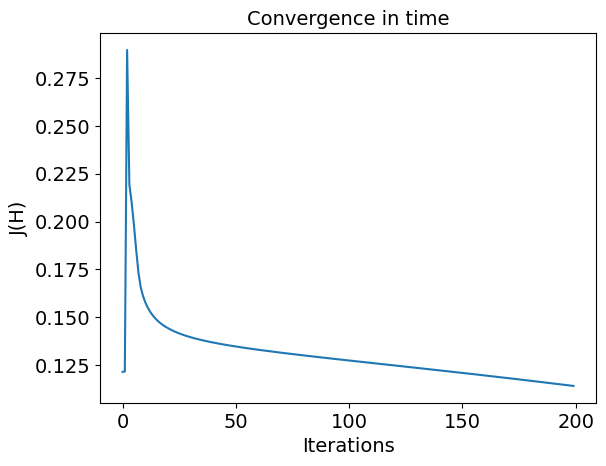

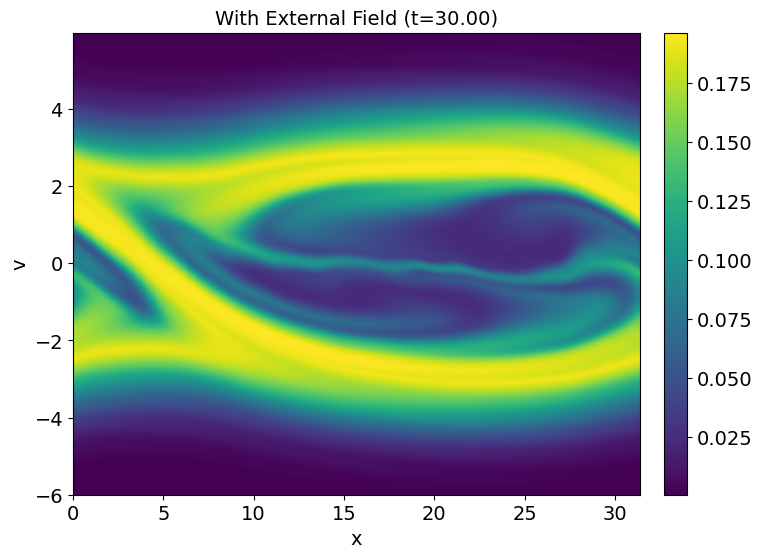

In [11]:
# Optimization through auto-differentiation with fixed basis.

# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
 -0.0, 0])

# Function to compute the external field H based on coefficients a_k
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)
    for k in range(1, 15):  # k from 1 to 11
        H += a_k[k-1] * jnp.cos(k * xs / L * 2 * jnp.pi)
    return H

def kl_divergence(f_final, f_eq, solver, eps=1e-8):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = f_eq / (jnp.sum(f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(f_final * jnp.log(f_final / (f_eq + eps) + eps)) * solver.mesh.dx * solver.mesh.dv
    return kl_div

def cost_function_kl(a_k):
    H = compute_external_field(mesh.xs, a_k)
    # JIT-compiled forward solver
    solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    f_final = f_array
    cost = kl_divergence(f_final, f_eq, solver)
    return cost


# Compute the gradient using JAX's automatic differentiation
cost_and_grad_function = jax.jit(jax.value_and_grad(cost_function_kl))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Plot the final distribution before optimization using the initial guess of H
H_initial = compute_external_field(mesh.xs, a_k)
f_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)

f_final_initial = f_array_initial

# Print J (cost function value) for the initial guess
J_initial = kl_divergence(f_final_initial, f_eq, solver)
print(f'Initial cost J: {J_initial}')

# Create a figure for the initial plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution at the final time with the initial guess
plot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)

# Display the initial plot
plt.show()

# Now proceed with the optimization loop
maxIter = 200  # Number of optimization iterations
hist_J = []

for i in range(maxIter):
    # Compute cost and gradient
    cost, grad = cost_and_grad_function(a_k)
    hist_J.append(cost)
    if i%10 == 0:
        print(f'Iteration {i}, Cost: {cost}')
        #print(f'Iteration {i}, a_k: {a_k}')  # Print the current value of a_k
    
    # Update a_k using a simple gradient descent step or line search
    # For simplicity, let's use gradient descent with a fixed learning rate
    learning_rate = 0.001
    a_k = a_k - learning_rate * grad
    
    # After each iteration, plot the distribution
    H = compute_external_field(mesh.xs, a_k)
    ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
    f_final = ff_array

# Plot the value of the cost function during the iteration process
plt.plot(hist_J)
plt.title('Convergence in time')
plt.ylabel('J(H)')
plt.xlabel('Iterations')
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()

In [ ]:
@dataclasses.dataclass(frozen=True)
class VlasovPoissonSolverParticles(VlasovPoissonSolver):

    def generate_particles_equilibrium_two_stream(self, f, N, L, v_max):
    """
    Generates N^2 particles uniformly distributed on the domain.
    Evaluates the function f(x, v) at the center of each small square.

    Parameters:
    f (function): Function of x and v, f(x,v)
    N (int): Number of grid points along each dimension (total N^2 particles)
    L (float): Length of the domain for x (domain [0, L])
    v_max (float): Maximum value for v (domain [-v_max, v_max])
    epsilon (float): Perturbation parameter for normalization
    beta (float): Spatial frequency for normalization

    Returns:
    particles (list): A list of particles, where each particle is represented as a tuple (x, v, weight)
    """    
    # Create the particle list
    #particles = []
    particles = jnp.zeros((N**2,3))

        def build_particle(i):
            x = (i + 0.5) * self.mesh.dx
    # Loop over each point in the x grid
    for i in range(N):
        x = (i + 0.5) * self.mesh.dx  # Center of the current x cell
        normalization_factor = self.mesh.dx  # Target sum for weights over v

        # Store the weights for this x over all velocities
        # weights = []
        weights = jnp.zeros(N)
        for j in range(N):
            v = -v_max + (j + 0.5) * self.mesh.dv  # Center of the current v cell
            weight = f(x, v) * self.mesh.dx * self.mesh.dv
            weights = weights.at[j].set(weight)
            #weights.append(weight)

        # Normalize weights for the current x to match the desired sum
        weight_sum = jnp.sum(weights)
        if weight_sum != 0:  # Avoid division by zero
            normalized_weights = [w * normalization_factor / weight_sum for w in weights]
        else:
            normalized_weights = weights  # If the sum is zero, no need to normalize

        # Append the particles with the normalized weights
        for j, v in enumerate(np.linspace(-v_max + 0.5 * dv, v_max - 0.5 * dv, N)):
            particle = jnp.array([x,v,normalized_weights[j]])
            particles = particles.at[i*N+j,:].set(particle)
            #particles.append((x, v, normalized_weights[j]))

    return particles

    
    def compute_rho(self, particles: Array) -> Array:
        # Initialize rho(x) for each cell
        rho_x = jnp.zeros(N)
    
        # Loop over the particles and accumulate their weights in the corresponding cell
        for x, _, weight in particles:
            # Find the index of the cell where this particle falls
            cell_index = int(x // self.mesh.dx)  # Find which cell the particle belongs to
            rho_x = rho_x.at[cell_index].add(weight)  # Add the particle's weight to the cell
    
        # Compute the x positions of the cell centers
        x_centers = (jnp.arange(N) + 0.5) * self.mesh.dx
    
        return x_centers, rho_x / self.mesh.dx

    def compute_E_from_rho(self, rho: Array) -> Array:
        rho_hat = jnp.fft.fft(rho)
        E_hat = jnp.zeros_like(rho_hat)
        inv_multiplier = -1.0 / (1j * 2 * jnp.pi * jnp.fft.fftfreq(self.mesh.nx, d=self.mesh.period_x / self.mesh.nx)[1:])
        E_hat = E_hat.at[1:].set(inv_multiplier * rho_hat[1:])
        return jnp.real(jnp.fft.ifft(E_hat))

    def compute_E(self, particles: Array) -> Array:
        return self.compute_E_from_rho(self.compute_rho(pparticles))

    def compute_electric_energy(self, E: Array) -> Array:
        return 0.5 * jnp.sum(jnp.square(E)) * self.mesh.dx

# TO DO: write integration step of particle system
